In [92]:
import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model, Model, save_model
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv3D, Conv3DTranspose, Conv2D, Conv1D, Dropout, MaxPooling2D, LeakyReLU, BatchNormalization, Reshape, InputLayer, Input, ZeroPadding3D, ZeroPadding2D, UpSampling2D, UpSampling3D, MaxPool3D, MaxPooling3D
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from keras import backend as K

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}

In [93]:
# example of horizontal shift image augmentation
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image

def load_dataset():    
    # Download and load the dataset.
    fpath = keras.utils.get_file(
        "moving_mnist.npy",
        "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
    )
    dataset = np.load(fpath)    
    dataset = np.swapaxes(dataset, 0, 1)
    dataset = np.expand_dims(dataset, 4)    
    dataset = dataset[:, :, ::2, ::2, :]  
    return dataset

dataset_20 = load_dataset()
dataset0 = dataset_20[:, :10, ...]
dataset1 = dataset_20[:, 10:, ...]
print(dataset0.shape)
dataset = np.concatenate((dataset0, dataset1))
print(dataset.shape)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.seed(42)
np.random.shuffle(indexes)
train_index = indexes[: int(0.8 * dataset.shape[0])]
val_index = indexes[int(0.8 * dataset.shape[0]) : int(0.95 * dataset.shape[0])]
test_index = indexes[int(0.95 * dataset.shape[0]) :]

"""train_dataset = (dataset[train_index] - 127.5) / 127.5
val_dataset = (dataset[val_index] - 127.5) / 127.5
test_dataset = (dataset[test_index] - 127.5) / 127.5"""
train_dataset = (dataset[train_index] / 255.)
val_dataset = (dataset[val_index] / 255.)
test_dataset = (dataset[test_index] / 255.)
print(train_dataset.shape)

(10000, 10, 32, 32, 1)
(20000, 10, 32, 32, 1)
(16000, 10, 32, 32, 1)


In [94]:
x_train_data = np.array(train_dataset)
x_train_data[:, 1:9, :, :, :] = 0
y_train_data = train_dataset

x_val_data = np.array(train_dataset)
x_val_data[:, 1:9, :, :, :] = 0
y_val_data = train_dataset

x_test_data = np.array(train_dataset)
x_test_data[:, 1:9, :, :, :] = 0
y_test_data = train_dataset

print(x_train_data.shape)
print(x_val_data.shape)
print(x_test_data.shape)

(16000, 10, 32, 32, 1)
(16000, 10, 32, 32, 1)
(16000, 10, 32, 32, 1)


In [95]:
def display_img(img):
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))        
    ax.imshow(img, cmap='gray')

def display_seq(data, label='Frame'):
    fig, axes = plt.subplots(1, 10, figsize=(25, 5))
    ax = axes.flatten()    
    for i, frame in enumerate(data): 
        if i >= 10:
            break
        ax[i].set_title(f"{label} {i}")
        ax[i].imshow(frame, cmap='gray')
        ax[i].axis("off")

In [96]:
img_shape = x_train_data[0].shape
print(img_shape)

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean
    
def build_model():
    codings_size = 1
    print("codings_size: ", codings_size)
    inputs = Input(shape=img_shape)
    z = Conv3D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_initializer='GlorotNormal')(inputs)
    z = Conv3D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_initializer='GlorotNormal')(z)
    z = BatchNormalization(momentum=0.8)(z)
    codings_mean = Dense(codings_size)(z)
    codings_log_var = Dense(codings_size)(z)
    codings = Sampling()([codings_mean, codings_log_var])
    encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])        
    
    decoder_inputs = Input(shape=(10,32,32,1))
    x = Conv3D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_initializer='GlorotNormal')(decoder_inputs)
    x = Conv3D(filters=1, kernel_size=3, activation='relu', padding='same', kernel_initializer='GlorotNormal')(x)
    
    decoder = Model(inputs=[decoder_inputs], outputs=[x])
    
    _, _, codings = encoder(inputs)
    reconstructions = decoder(codings)
    variational_ae = Model(inputs=[inputs], outputs=[reconstructions])
    
    latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
    variational_ae.add_loss(K.mean(latent_loss / 1024.))
    variational_ae.compile(loss='mse', optimizer='nadam')
    
    return variational_ae, encoder, decoder
    
model, encoder, decoder = build_model()
model.summary()

(10, 32, 32, 1)
codings_size:  1
Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 10, 32, 32,  0           []                               
                                 1)]                                                              
                                                                                                  
 model_39 (Functional)          [(None, 10, 32, 32,  28770       ['input_27[0][0]']               
                                 1),                                                              
                                 (None, 10, 32, 32,                                               
                                 1),                                                              
                                 (None, 10, 32, 32,       

In [97]:
import time
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import pickle
start_time = time.time()
LOG_DIR = f"./logs/{int(time.time())}"

print(x_train_data.shape)
print(y_train_data.shape)

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2)

model.fit(
    x=x_train_data,
    y=y_train_data,
    epochs=500,
    batch_size=64,
    validation_data=(x_val_data, y_val_data),
    callbacks=[early_stopping, reduce_lr] # keras.callbacks.TensorBoard("./tb_logs")
    )

import pickle
checkpoint_filepath = './savedModels/03_nonRecursive_conv_vae_v02.pickle'
with open(checkpoint_filepath, "wb") as save_file:
    pickle.dump(model, save_file)

print("--- %s seconds ---" % (time.time() - start_time))

(16000, 10, 32, 32, 1)
(16000, 10, 32, 32, 1)
Epoch 1/500
250/250 [==============================] - 30s 114ms/step - loss: 0.0328 - val_loss: 0.0294 - lr: 0.0010
Epoch 2/500
250/250 [==============================] - 27s 108ms/step - loss: 0.0281 - val_loss: 0.0274 - lr: 0.0010
Epoch 3/500
250/250 [==============================] - 27s 109ms/step - loss: 0.0272 - val_loss: 0.0270 - lr: 0.0010
Epoch 4/500
250/250 [==============================] - 27s 110ms/step - loss: 0.0270 - val_loss: 0.0268 - lr: 0.0010
Epoch 5/500
250/250 [==============================] - 27s 110ms/step - loss: 0.0268 - val_loss: 0.0267 - lr: 0.0010
Epoch 6/500
250/250 [==============================] - 28s 112ms/step - loss: 0.0268 - val_loss: 0.0267 - lr: 0.0010
Epoch 7/500
250/250 [==============================] - 28s 112ms/step - loss: 0.0266 - val_loss: 0.0266 - lr: 1.0000e-04
Epoch 8/500
250/250 [==============================] - 28s 113ms/step - loss: 0.0266 - val_loss: 0.0266 - lr: 1.0000e-04
Epoch 9/50

In [98]:
with open(checkpoint_filepath, "rb") as load_file:    
    model = pickle.load(load_file)

In [99]:
# Clamp images, else the predictions get very blurry
# theta: threshold to decide where to clip values
# epsilon: keep some values unclipped, to avoid too jagged edges
def clamp_image_array(y_hat, theta=.3, epsilon=.1):        
    y_hat_p = np.where(y_hat < theta - epsilon, 0, y_hat)
    y_hat_p = np.where(y_hat_p >= theta + epsilon, 1, y_hat_p)
    return y_hat_p

/tmp/ipykernel_22288/2984972139.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 10, figsize=(25, 5))


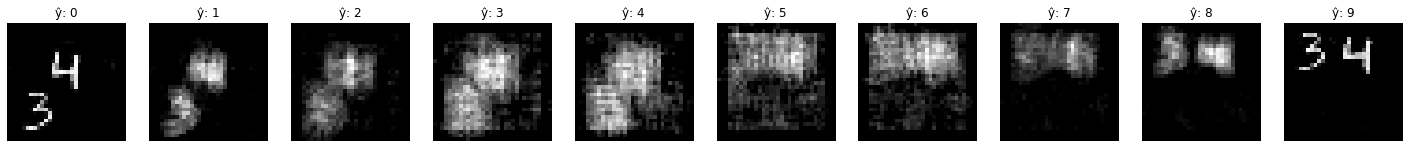

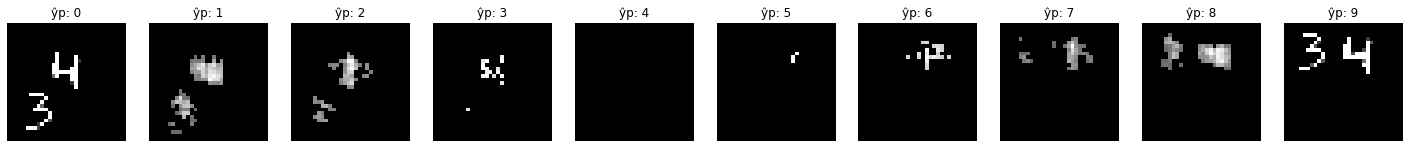

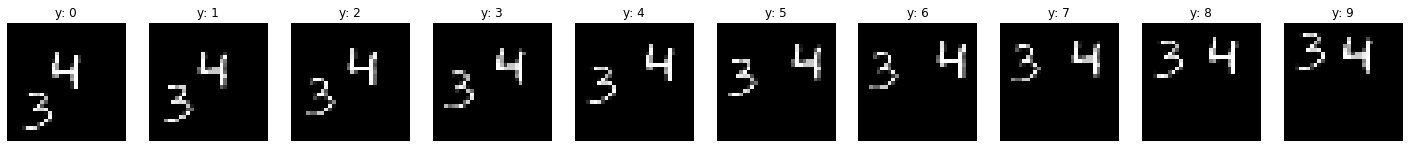

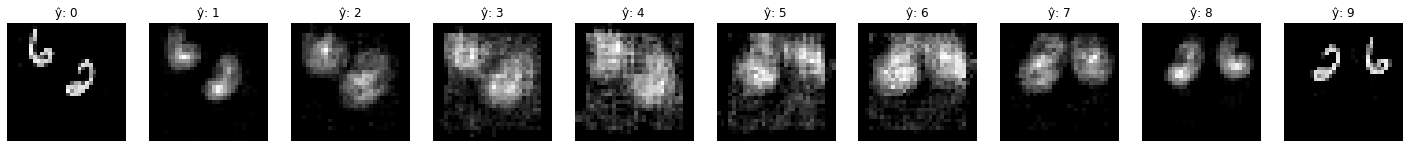

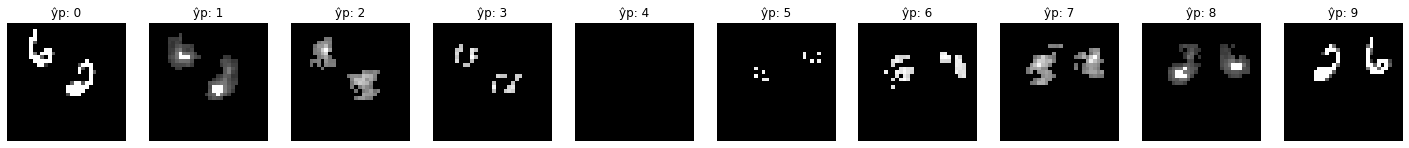

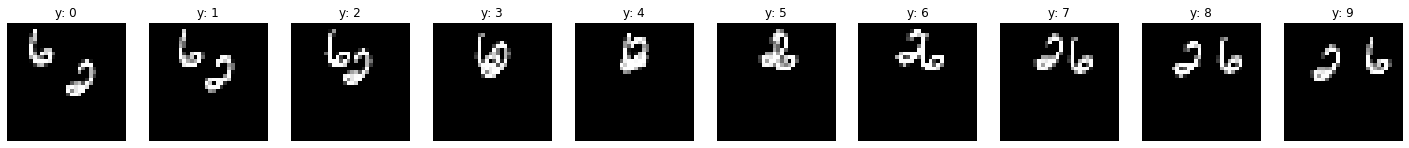

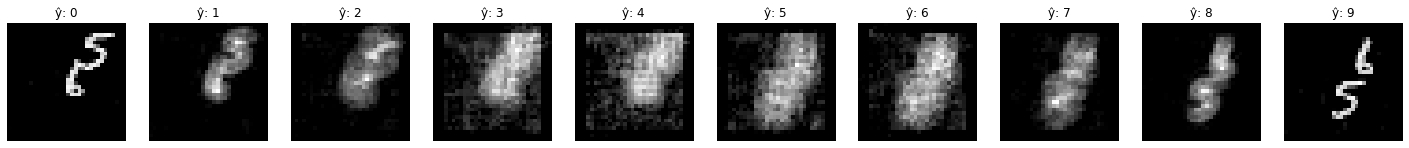

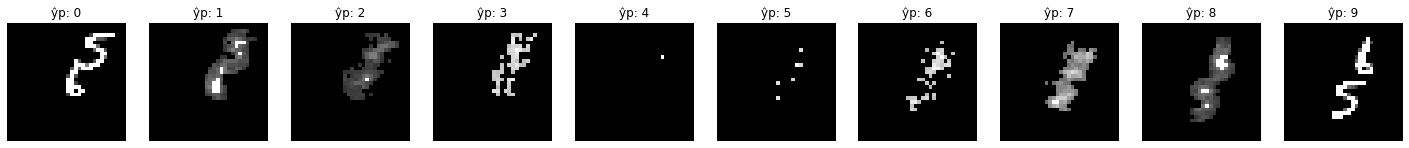

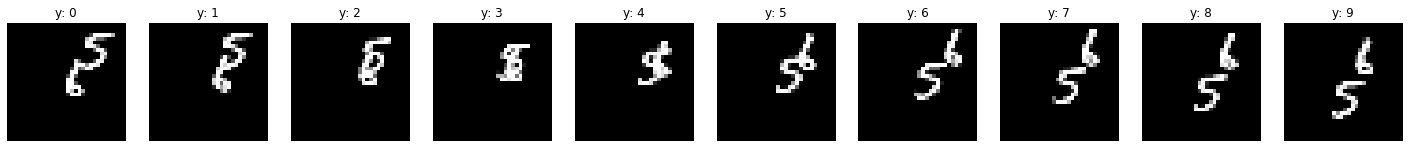

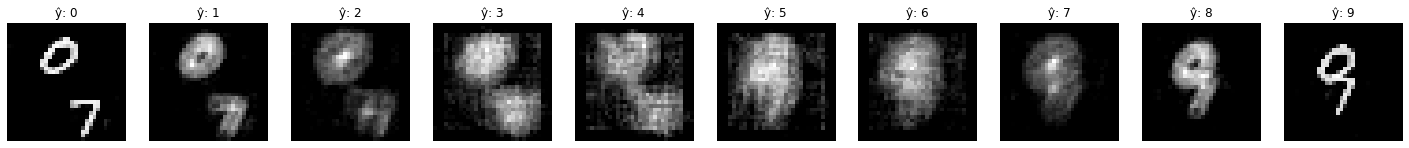

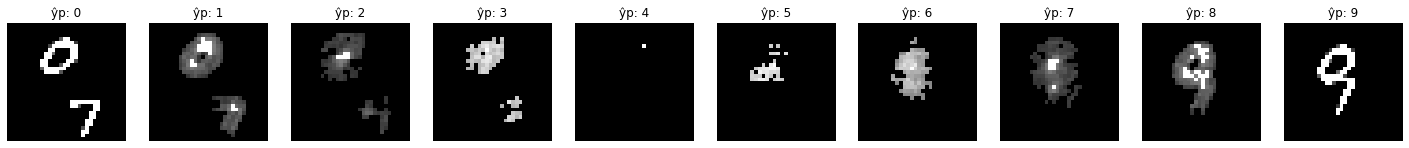

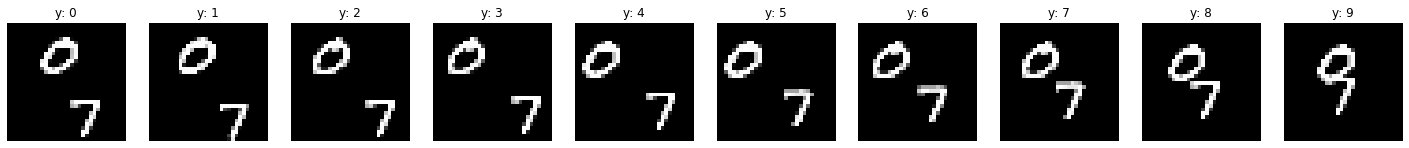

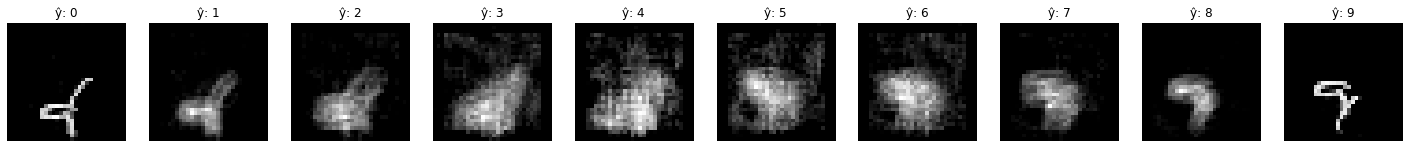

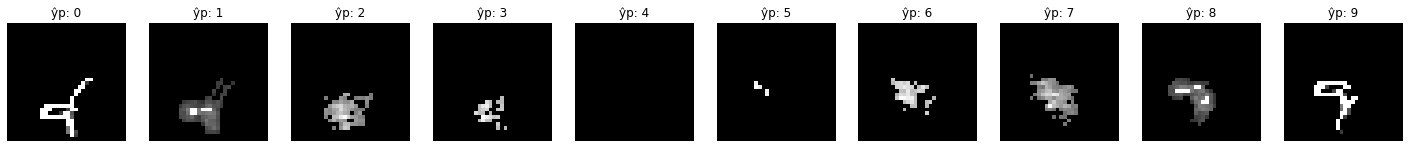

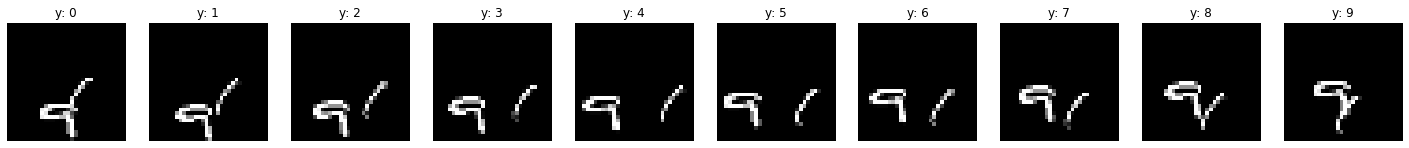

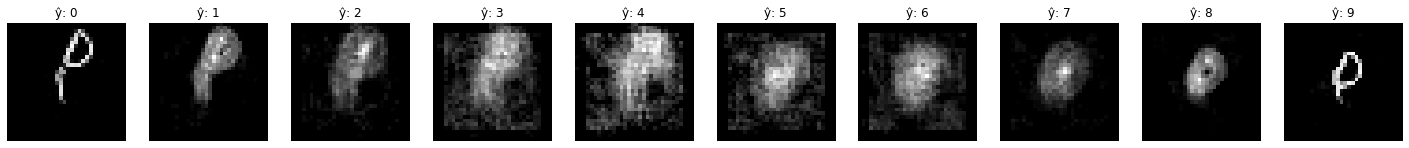

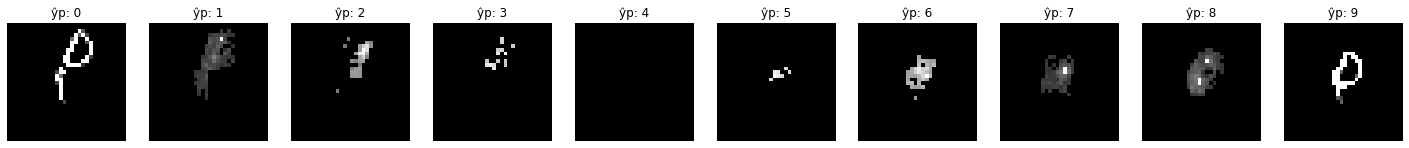

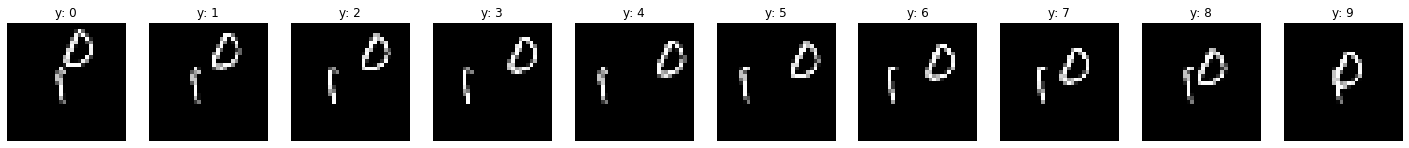

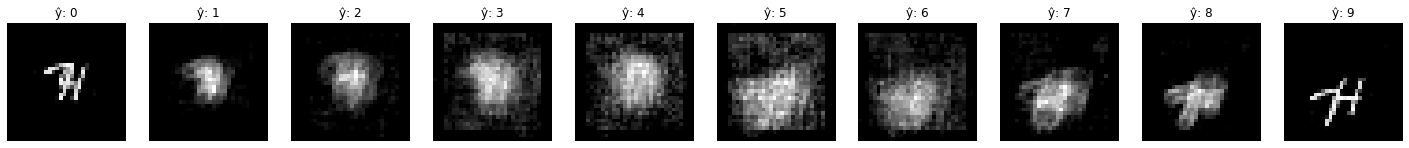

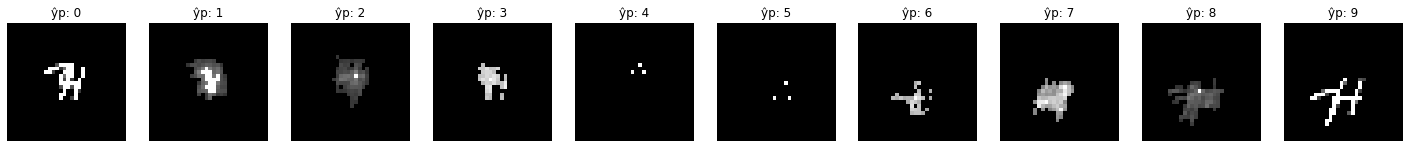

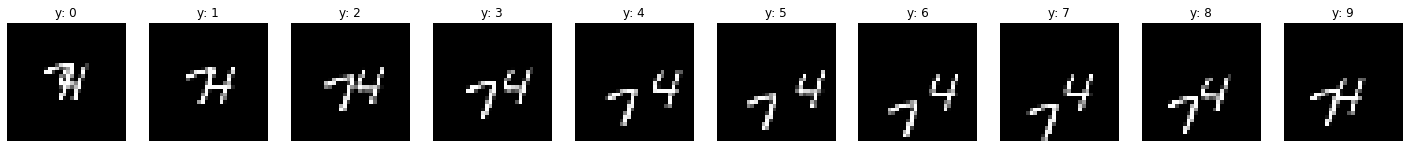

In [100]:
good = [22, 44, 52, 64, 73, 76, 94]
for i in good:
    test_set = test_dataset[i, :, :, :, :]
    test_set = np.expand_dims(test_set, axis=0)
    y_test_set = np.array(test_set)
    x_test_set = np.array(test_set)
    x_test_set[:, 1:9, :, :, :] = 0
    
    yhat = model.predict(x_test_set)

    display_seq(yhat[0], 'ŷ:')
    display_seq(clamp_image_array(yhat[0], theta=.35, epsilon=0.15), 'ŷp:')
    display_seq(y_test_set[0], 'y:')

NameError: name 'sharpen_image_array' is not defined

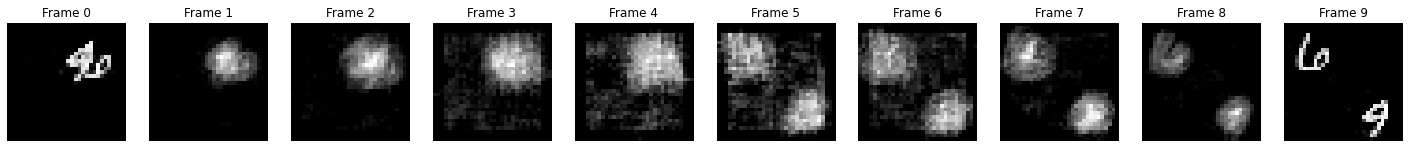

In [101]:
for i in range(8):    
    predicted_animation = model.predict(x_test_data[i:i+1,...])
    display_seq(predicted_animation[0])
    display_seq(sharpen_image_array(predicted_animation[0], .25, .15, .45))
    display_seq(y_test_data[i:i+1,...][0])